---
title: 'ACP 166: Datos abiertos para ciudades resilientes'
subtitle: 'Unidad 2: Datos abiertos para ciudades y clima'
---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nlebovits/datos-escala-humana/blob/main/es/datos-abiertos/taller.ipynb)

En esta lección, consideraremos una serie de conjuntos de datos de código abierto relacionados con la exposición poblacional. Compararemos datos del INDEC argentino, GHSL y huellas de edificios abiertas para intentar estimar la población en asentamientos informales alrededor de La Plata. En particular, intentaremos comprender los propios conjuntos de datos: cómo y cuándo se elaboraron, qué contienen, quién los mantiene y, fundamentalmente, qué tan confiables son.

## Sección 1: Población en barrios populares

In [1]:
import geopandas as gpd
from io import BytesIO
import os
from owslib.wfs import WebFeatureService
import numpy as np
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterstats
import duckdb
import pandas as pd
from scipy import stats
import contextily as cx

# constantes de CRS
USE_CRS = "EPSG:5348"  # POSGAR 2007 / Argentina 4
WEB_MERCATOR_CRS = "EPSG:3857"  # visualización
WGS84_CRS = "EPSG:4326"  # consultas API

### 1.1 Datos RENABAP

Para comenzar, importaremos la fuente de datos oficial de Argentina sobre asentamientos informales: el Registro Nacional de Barrios Populares (RENABAP). Según [su documentación](https://www.argentina.gob.ar/obras-publicas/sisu/renabap/observatorio-de-barrios-populares), incluyen información sobre límites geográficos y datos sociodemográficos, y se basan en relevamientos barriales bajo la dirección de la Subsecretaría de Integración Socio Urbana, con el apoyo de RENAPER y ANSES.

Una observación importante sobre estos datos es que la versión más reciente (2023) se calculó utilizando _proyecciones_ basadas en los datos del censo nacional argentino de 2010. Dada la rapidez con la que pueden cambiar los asentamientos informales, esto plantea la posibilidad de que las estimaciones estén significativamente desfasadas con respecto a la situación real--que es precisamente lo que exploraremos en este taller.

Obtendremos nuestros datos de RENABAP de un archivo GeoJSON estático disponible en https://www.argentina.gob.ar/sites/default/files/renabap-2023-12-06.geojson. Curiosamente, no hay una API pública ni un botón de descarga para estos datos; en cambio, pueden encontrarse en el código fuente de la página del [mapa web público de RENABAP de asentamientos informales](https://www.argentina.gob.ar/obras-publicas/sisu/renabap/mapa):

![RENABAP map source](/home/nissim/Documents/dev/datos-escala-humana/public/renabap-mapa-source.png)

Como los datos están disponibles como un archivo plano (un conjunto de datos único y estático que se descarga, en lugar de un servidor o base de datos que se consulta dinámicamente), podemos cargarlos directamente desde esta URL usando `GeoPandas`.

In [2]:
renabap_ruta = (
    "https://www.argentina.gob.ar/sites/default/files/renabap-2023-12-06.geojson"
)

renabap = gpd.read_file(renabap_ruta)

renabap_pba = renabap[renabap["provincia"] == "Buenos Aires"]

renabap_pba = renabap_pba.to_crs(USE_CRS)

En teoría, tenemos una idea general de qué contiene el conjunto de datos, gracias a la documentación de RENABAP. Pero para entenderlo realmente, tenemos que realizar un _análisis exploratorio de datos_ (o "EDA"). Comenzaremos revisando lo básico: el tamaño de los datos, cómo se ven las primeras filas y cuáles son las distribuciones de los datos.

In [ ]:
renabap_pba.shape

(2065, 7)

In [3]:
renabap_pba.head()

id_renabap nombre_barrio     provincia departamento            localidad  \
0           1   Monterrey I  Buenos Aires        Pilar    Presidente Derqui   
1           2   Malvinas II  Buenos Aires     La Plata  José Melchor Romero   
2           3   Ferroviario  Buenos Aires     La Plata     Angel Etcheverry   
3           4   La Favelita  Buenos Aires     La Plata               Tolosa   
4           5        Casaca  Buenos Aires     La Plata            City Bell   

   familias_aproximadas                                           geometry  
0                    44  MULTIPOLYGON (((6331563.369 6183392.384, 63315...  
1                   319  MULTIPOLYGON (((6407555.589 6132750.136, 64078...  
2                   146  MULTIPOLYGON (((6401466.885 6122949.29, 640148...  
3                   134  MULTIPOLYGON (((6410444.382 6137104.402, 64104...  
4                    22  MULTIPOLYGON (((6402845.212 6137802.877, 64028...

Entonces, ¿cuántos nombres _únicos_ hay para los barrios? ¿Cuántos asentamientos hay por departamento? ¿Y por localidad? ¿Cuál es el número promedio de familias por barrio? ¿Mínimo? ¿Máximo? ¿Total?

In [4]:
print(f"Nombres únicos de barrios: {renabap_pba['nombre_barrio'].nunique()}")

print("\nAsentamientos por departamento:")
print(renabap_pba.groupby("departamento").size())
print("\nAsentamientos por localidad:")
print(renabap_pba.groupby("localidad").size())

print("\nEstadísticas de familias aproximadas:")
print(f"Promedio: {renabap_pba['familias_aproximadas'].mean():.2f}")
print(f"Mínimo: {renabap_pba['familias_aproximadas'].min()}")
print(f"Máximo: {renabap_pba['familias_aproximadas'].max()}")
print(f"Total: {renabap_pba['familias_aproximadas'].sum()}")
print("\nResumen estadístico completo:")
print(renabap_pba.describe())

Nombres únicos de barrios: 1507

Asentamientos por departamento:
departamento
25 de Mayo          4
9 de Julio          3
Almirante Brown    74
Arrecifes           5
Avellaneda         45
                   ..
Tres de Febrero    20
Vicente López      15
Villa Gesell        8
Villarino          13
Zárate             36
Length: 90, dtype: int64

Asentamientos por localidad:
localidad
Abasto                   4
Aldo Bonzi               1
Alejandro Korn          14
Altos De San Lorenzo    14
Angel Etcheverry         5
                        ..
Wilde                    1
William Morris          10
Zelaya                   1
Zona De Reserva          2
Zárate                  30
Length: 295, dtype: int64

Estadísticas de familias aproximadas:
Promedio: 285.12
Mínimo: 9
Máximo: 8635
Total: 588779

Resumen estadístico completo:
        id_renabap  familias_aproximadas
count  2065.000000           2065.000000
mean   2082.995157            285.123002
std    2062.617169            513.854272
min 

Ahora, usaremos el mismo conjunto de datos de partidos del taller anterior para obtener los límites de La Plata.

In [5]:
partidos_path = "data/pba_partidos.geojson"

# Cargar partidos desde el servicio WFS de ARBA GeoServer
if os.path.exists(partidos_path):
    partidos = gpd.read_file(partidos_path)
else:
    # Conectar al servicio WFS (Web Feature Service)
    wfs_url = "https://geo.arba.gov.ar/geoserver/idera/wfs"
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")

    # Solicitar la capa de Departamento (partidos)
    response = wfs.getfeature(
        typename="idera:Departamento",
        srsname="EPSG:5347",  # CRS original
    )

    # Convertir respuesta WFS a GeoDataFrame
    partidos = gpd.read_file(BytesIO(response.read()))

    # Guardar en caché para uso futuro
    partidos.to_file(partidos_path, driver="GeoJSON")

# Reproyectar al CRS de trabajo
partidos = partidos.to_crs(USE_CRS)

la_plata = partidos[partidos["fna"] == "Partido de La Plata"]

# Obtener la geometría principal y mantener solo el polígono más grande
# Esto elimina pequeñas islas que aparecen en los datos
la_plata = la_plata.copy()
main_geom = la_plata.geometry.iloc[0]
la_plata.loc[la_plata.index[0], "geometry"] = max(main_geom.geoms, key=lambda p: p.area)

Al igual que con las cuencas en el taller anterior, filtraremos los asentamientos informales que _intersectan_ con los límites de La Plata. Es importante hacer esto y no _recortar_ (lo cual truncaría nuestros asentamientos informales cortando literalmente partes de ellos), o elegir el predicado espacial incorrecto como "dentro de", lo cual excluiría asentamientos que no caen 100% dentro de los límites de La Plata. Dado que los asentamientos informales suelen ocurrir en el borde de los asentamientos formales, esto es especialmente importante.

In [6]:
renabap_la_plata = renabap_pba[
    renabap_pba.geometry.intersects(
        la_plata.union_all()
    )  # union_all() combina todas las geometrías de La Plata en caso de que haya múltiples polígonos
].copy()  # .copy() crea una copia independiente para evitar advertencias al modificar

Ahora, vamos a visualizar nuestros datos. Nos aseguraremos de incluir los límites de La Plata para contexto, y agregaremos un paso adicional: colorear los asentamientos informales según el número de familias que tienen según RENABAP.

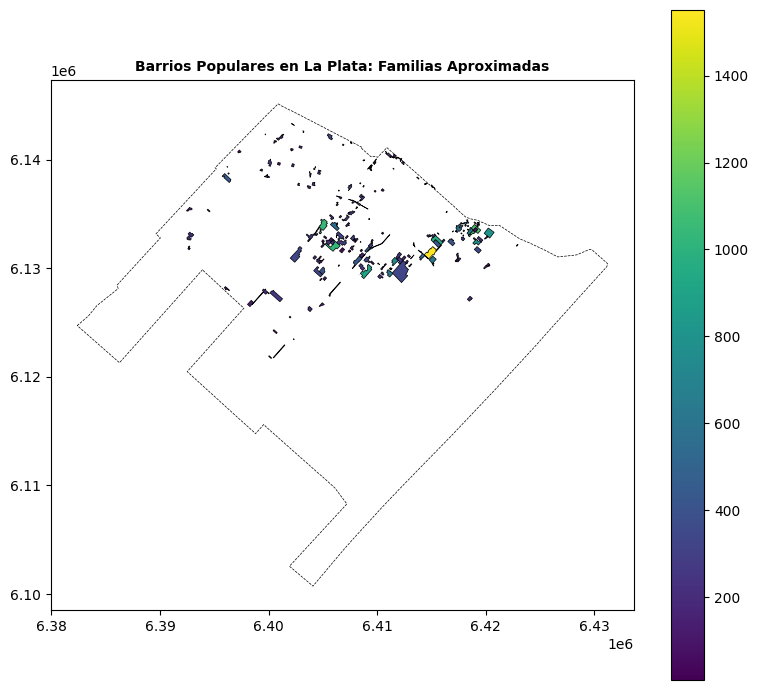

In [7]:
fig, ax = plt.subplots(figsize=(8, 7))


renabap_la_plata.plot(
    "familias_aproximadas",
    ax=ax,
    legend=True,
    cmap="viridis",
    edgecolor="black",
    linewidth=0.5,
)

la_plata.boundary.plot(ax=ax, color="black", linewidth=0.5, linestyle="--")

ax.set_title(
    "Barrios Populares en La Plata: Familias Aproximadas",
    fontsize=10,
    fontweight="bold",
)

plt.tight_layout()
plt.show()

Ahora que hemos filtrado para La Plata, podemos comenzar a realizar estadísticas descriptivas más significativas. Nuevamente, analizaremos la _distribución_ de la población estimada en asentamientos informales _solo en el área de La Plata_.

In [8]:
renabap_la_plata["familias_aproximadas"].describe()

count     167.000000
mean      203.131737
std       238.285607
min         9.000000
25%        46.000000
50%       132.000000
75%       252.000000
max      1551.000000
Name: familias_aproximadas, dtype: float64

Un histograma puede ayudarnos a obtener una mejor idea de la distribución. Un histograma es un gráfico que muestra la frecuencia de valores en diferentes rangos, permitiéndonos visualizar cómo se distribuyen los datos.

array([[<Axes: title={'center': 'familias_aproximadas'}>]], dtype=object)

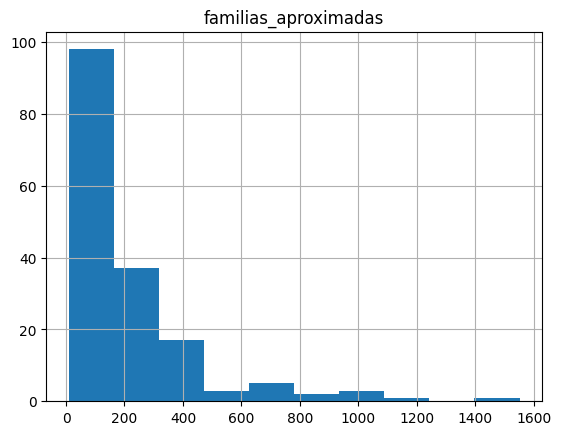

In [9]:
renabap_la_plata.hist("familias_aproximadas")

También podemos mostrar los nombres de los barrios más grandes y más pequeños.

In [10]:
largest = renabap_la_plata.loc[renabap_la_plata["familias_aproximadas"].idxmax()]
print(
    f"Barrio más grande: {largest['nombre_barrio']} ({largest['familias_aproximadas']} familias)"
)

smallest = renabap_la_plata.loc[renabap_la_plata["familias_aproximadas"].idxmin()]
print(
    f"Barrio más pequeño: {smallest['nombre_barrio']} ({smallest['familias_aproximadas']} familias)"
)

Barrio más grande: Puente de Fierro (1551 familias)
Barrio más pequeño: La Hermosura (9 familias)


Ahora tenemos una buena idea de qué contiene el conjunto de datos de RENABAP. Sin embargo, como recordamos, la metodología utilizada para producir los datos nos da razones para creer que estos datos pueden no ser muy precisos. A continuación, recurriremos a un conjunto de datos de población global como nuestro primer punto de comparación.

### 1.2 Datos GHSL

Existen varios conjuntos de datos globales que pueden darnos información sobre patrones de población. Algunos de los comúnmente utilizados en análisis de riesgo climático incluyen la Capa Global de Asentamientos Humanos (GHSL), WorldPop y la Capa de Asentamientos de Alta Resolución. Estos conjuntos de datos típicamente se derivan de una combinación de imágenes satelitales y datos auxiliares, como edificios y carreteras globales o luces nocturnas, y se estiman usando modelos de aprendizaje automático. Cada uno de estos conjuntos de datos tiene ventajas y limitaciones: algunos tienen mayor resolución o mejor cobertura temporal o mejor consistencia metodológica. Aquí, usaremos GHSL porque era el conjunto de datos con la mayor resolución y mejor cobertura temporal disponible en el momento de la escritura, además de ser el conjunto de datos elegido por Floodbase, una compañía global de riesgo de inundaciones [@tellman2021].

La [Capa Global de Asentamientos Humanos (Global Human Settlement Layer)](https://human-settlement.emergency.copernicus.eu/ghs_pop2023.php) [@ghsl_pop2023a] es un conjunto de datos de resolución de 100 metros que proporciona estimaciones de población multitemporales (1975-2030) derivadas de datos censales y administrativos, informadas por la distribución y clasificación de áreas construidas. Para este análisis se utilizan los datos GHSL de 2023, que son los más recientes disponibles. Sin embargo, note que estos fueron publicados en 2023, lo que significa que también son _proyecciones_, no estimaciones de 2025 en sí.

Aquí, importaremos los datos GHSL desde un GeoTIFF optimizado para la nube, que es un formato de archivo diseñado para el acceso eficiente de conjuntos de datos almacenados remotamente. Para nuestros propósitos, esto significa que es fácil cargarlos directamente sin usar mucha memoria o tener que descargar un archivo local.

In [11]:
# URL del archivo GHSL que contiene los datos de población
ghsl_url = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2025_GLOBE_R2023A_54009_100/V1-0/tiles/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13.zip"

# Crear ruta virtual para acceder al archivo ZIP remoto sin descargarlo completamente
# vsizip permite leer archivos dentro de un ZIP, vsicurl permite leer desde una URL
vsi_path = (
    f"/vsizip/vsicurl/{ghsl_url}/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13.tif"
)

ghsl = rio.open_rasterio(
    vsi_path,
    chunks={"x": 2048, "y": 2048},
)

Recordamos que hay algunos asentamientos informales que no caen completamente dentro de los límites oficiales del Partido. Por lo tanto, si simplemente recortamos los datos GHSL a los límites de La Plata, ¡estaremos cortando población que debería contarse como parte de los asentamientos informales! Para abordar esto, recortaremos usando el rectángulo delimitador de los asentamientos informales: el rectángulo más pequeño que engloba completamente todos los asentamientos. Esto asegurará que no estemos subestimando accidentalmente la población.

In [12]:
# Obtener los límites del área de los barrios y transformarlos al CRS de GHSL primero
bounds = renabap_la_plata.total_bounds
bounds_ghsl_crs = renabap_la_plata.to_crs(ghsl.rio.crs).total_bounds

ghsl_clipped = ghsl.rio.clip_box(
    minx=bounds_ghsl_crs[0],
    miny=bounds_ghsl_crs[1],
    maxx=bounds_ghsl_crs[2],
    maxy=bounds_ghsl_crs[3],
)

ghsl_clipped = ghsl_clipped.rio.reproject(
    dst_crs=USE_CRS,
)

# Manejar valores de no-datos: establecer a NaN todos los valores menores o iguales a -200
ghsl_clipped = ghsl_clipped.where(ghsl_clipped > -200)

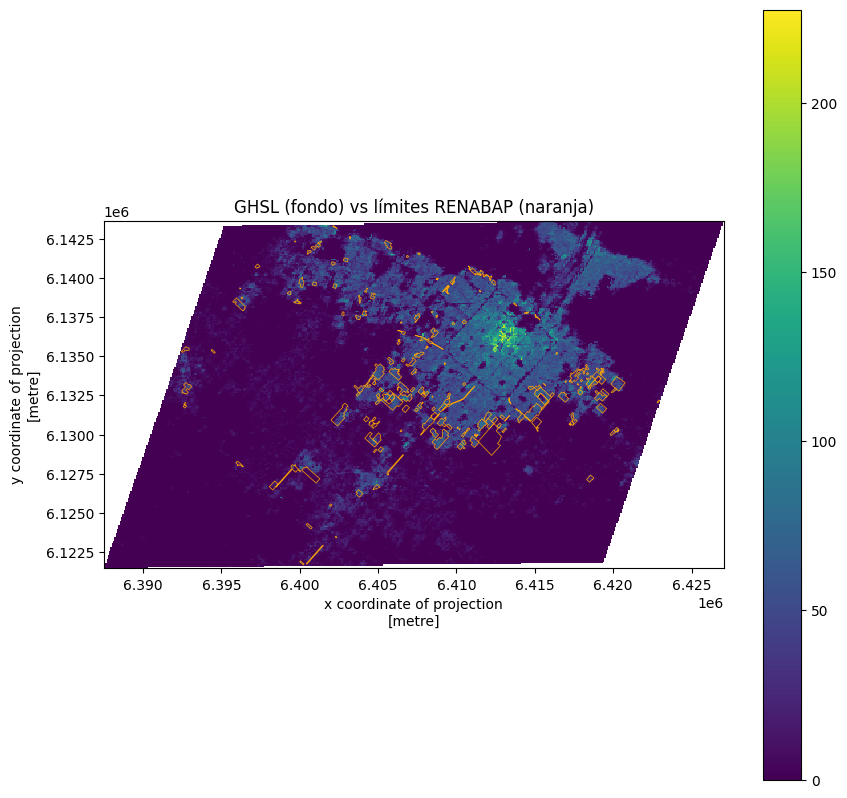

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
ghsl_clipped.plot(ax=ax, cmap="viridis")
renabap_la_plata.boundary.plot(ax=ax, color="orange", linewidth=0.5)
plt.title("GHSL (fondo) vs límites RENABAP (naranja)")
plt.show()

Ahora, para resumir la población estimada de GHSL por asentamiento informal, podemos usar _estadísticas zonales_, una herramienta que vimos en el taller anterior. Las estadísticas zonales nos permiten calcular diversas estadísticas descriptivas (por ejemplo, mínimo, media, suma, etc.) para la parte de un ráster que cae dentro de ciertos datos vectoriales. En este caso, queremos calcular la _suma_ de las estimaciones de población GHSL dentro de cada asentamiento informal.

Una particularidad importante de las estadísticas zonales es cómo manejan las celdas que _parcialmente_ intersectan con un barrio dado. ¿Incluyen el valor de la celda en la suma o no? Aquí, lo calcularemos de ambas maneras: una columna, `ghsl_pop_est_alta`, que _incluye_ estos valores, y una columna, `ghsl_pop_est_alta`, que los _excluye_. ¿Cómo crees que estas decisiones impactarán los totales de población estimada por asentamiento?

In [14]:
# Extraer las geometrías de los barrios para las estadísticas zonales
barrio_geometries = [geom for geom in renabap_la_plata.geometry]

# Usar NaN como valor de no-datos (rasterstats maneja NaN automáticamente)
# Calcular estadísticas zonales con all_touched=True (incluye celdas que parcialmente intersectan)
ghsl_stats_alta = rasterstats.zonal_stats(
    barrio_geometries,
    ghsl_clipped.values[0],
    affine=ghsl_clipped.rio.transform(),
    stats=["sum"],
    nodata=np.nan,
    all_touched=True,
)

# Calcular estadísticas zonales con all_touched=False (solo celdas cuyo centro cae dentro del barrio)
ghsl_stats_baja = rasterstats.zonal_stats(
    barrio_geometries,
    ghsl_clipped.values[0],
    affine=ghsl_clipped.rio.transform(),
    stats=["sum"],
    nodata=np.nan,
    all_touched=False,
)

# Convertir los resultados a listas, reemplazando None con 0 para barrios sin datos
ghsl_sums_alta = [
    stat["sum"] if stat["sum"] is not None else 0 for stat in ghsl_stats_alta
]
ghsl_sums_baja = [
    stat["sum"] if stat["sum"] is not None else 0 for stat in ghsl_stats_baja
]

# Agregar las estimaciones de población GHSL al dataframe
renabap_la_plata["ghsl_pop_est_alta"] = ghsl_sums_alta
renabap_la_plata["ghsl_pop_est_baja"] = ghsl_sums_baja

In [15]:
print(
    f"\nTotal población GHSL (estimación alta): {renabap_la_plata['ghsl_pop_est_alta'].sum():.0f}"
)
print(
    f"Total población GHSL (estimación baja): {renabap_la_plata['ghsl_pop_est_baja'].sum():.0f}"
)


Total población GHSL (estimación alta): 144797
Total población GHSL (estimación baja): 83958


In [16]:
print("Estadísticas descriptivas - Estimación alta GHSL (all_touched=True):")
print(renabap_la_plata["ghsl_pop_est_alta"].describe())

Estadísticas descriptivas - Estimación alta GHSL (all_touched=True):
count     167.000000
mean      867.050386
std       979.799913
min        10.797288
25%       260.543555
50%       517.168147
75%      1136.468484
max      4928.496077
Name: ghsl_pop_est_alta, dtype: float64


array([[<Axes: title={'center': 'ghsl_pop_est_alta'}>]], dtype=object)

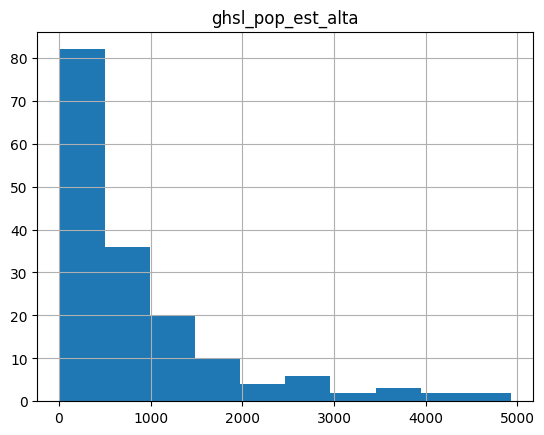

In [17]:
renabap_la_plata.hist("ghsl_pop_est_alta")

In [18]:
print("\nEstadísticas descriptivas - Estimación baja GHSL (all_touched=False):")
print(renabap_la_plata["ghsl_pop_est_baja"].describe())


Estadísticas descriptivas - Estimación baja GHSL (all_touched=False):
count     167.000000
mean      502.741114
std       723.267109
min         0.000000
25%        74.784593
50%       204.167852
75%       641.750965
max      4039.897740
Name: ghsl_pop_est_baja, dtype: float64


array([[<Axes: title={'center': 'ghsl_pop_est_baja'}>]], dtype=object)

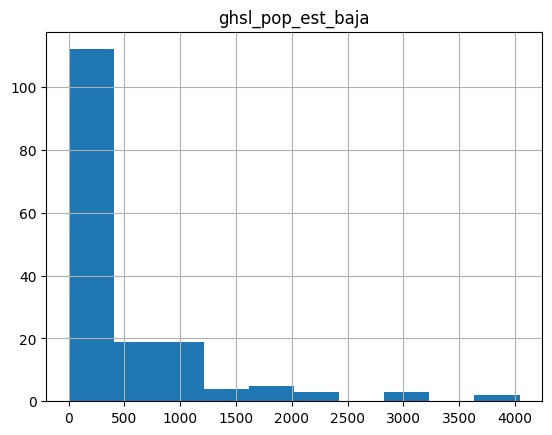

In [19]:
renabap_la_plata.hist("ghsl_pop_est_baja")

Ahora podemos comparar estos datos con las estimaciones de población de RENABAP. Aquí, es importante tener en cuenta que RENABAP reporta _familias_, mientras que GHSL reporta _población_. Por lo tanto, aunque esperamos que estos números sean _proporcionales_ entre sí, esperaríamos que las estimaciones de GHSL sean mayores (probablemente alrededor de 3 veces mayores, asumiendo aproximadamente 3 personas por familia).

In [20]:
print(
    f"Población GHSL (alta) por familias RENABAP: {renabap_la_plata['ghsl_pop_est_alta'].sum() / renabap_la_plata['familias_aproximadas'].sum():.2f}"
)

print(
    f"Población GHSL (baja) por familias RENABAP: {renabap_la_plata['ghsl_pop_est_baja'].sum() / renabap_la_plata['familias_aproximadas'].sum():.2f}"
)

Población GHSL (alta) por familias RENABAP: 4.27
Población GHSL (baja) por familias RENABAP: 2.47


Una herramienta que podemos usar aquí es calcular el _coeficiente de correlación_, que mide la fuerza de la relación entre estas dos variables. Los valores van de -1 a 1: cercanos a 1 indican una relación positiva fuerte; cercanos a -1, una relación negativa fuerte; cercanos a 0, poca relación. El valor p indica la significancia estadística (buscamos valores p de 0.05 o menores). Usamos el coeficiente de correlación de Spearman en lugar del de Pearson porque es más robusto para datos no lineales, con valores atípicos o problemas de calidad, comunes en análisis de asentamientos informales.

En este caso, vemos que ambas columnas de GHSL tienen correlaciones fuertes y positivas con los datos de RENABAP, lo que indica que siguen patrones similares. Esto es importante: una correlación alta no significa que las estimaciones coincidan en valores absolutos, sino que los barrios grandes según una fuente tienden a ser grandes según la otra, y los pequeños tienden a ser pequeños en ambas.

Sin embargo, hay consideraciones importantes: RENABAP reporta familias, mientras que GHSL reporta individuos. Aunque esperaríamos proporcionalidad (aproximadamente 3 personas por familia), existen diferencias sustanciales y valores atípicos con discrepancias considerables.

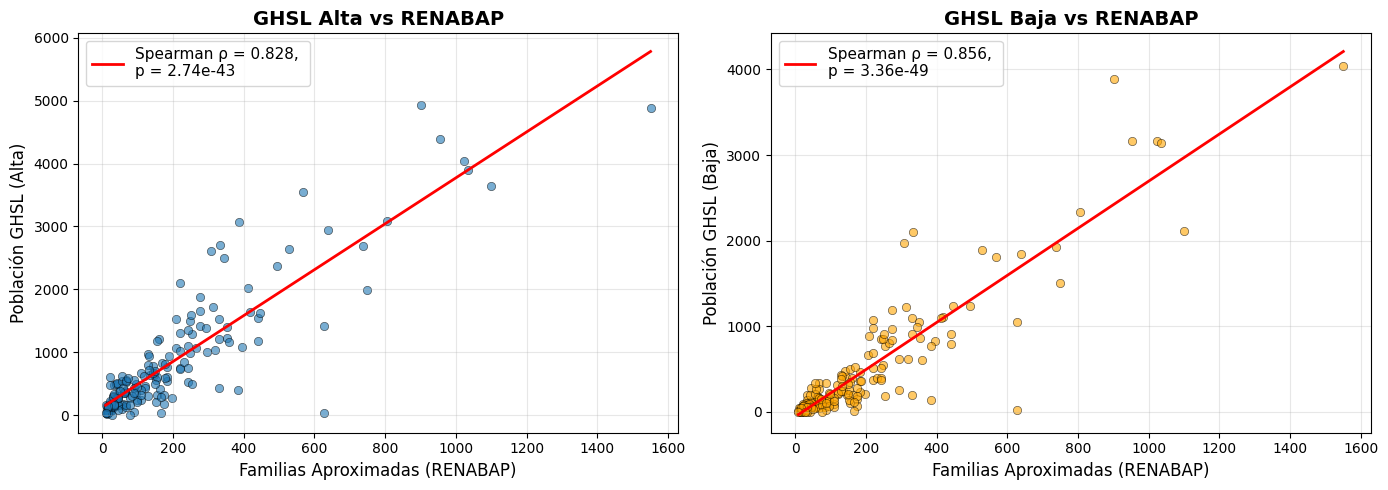

In [21]:
# Crear figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: GHSL Alta vs Familias RENABAP
ax1 = axes[0]
ax1.scatter(
    renabap_la_plata["familias_aproximadas"],
    renabap_la_plata["ghsl_pop_est_alta"],
    alpha=0.6,
    edgecolors="k",
    linewidth=0.5,
)

# Calcular correlación de Spearman para GHSL alta vs familias
rho1, p_value1 = stats.spearmanr(
    renabap_la_plata["familias_aproximadas"], renabap_la_plata["ghsl_pop_est_alta"]
)

# Agregar línea de regresión para referencia
slope1, intercept1 = np.polyfit(
    renabap_la_plata["familias_aproximadas"], renabap_la_plata["ghsl_pop_est_alta"], 1
)
x1 = np.array(
    [
        renabap_la_plata["familias_aproximadas"].min(),
        renabap_la_plata["familias_aproximadas"].max(),
    ]
)
ax1.plot(
    x1,
    intercept1 + slope1 * x1,
    "r-",
    linewidth=2,
    label=f"Spearman ρ = {rho1:.3f}, \np = {p_value1:.2e}",
)

ax1.set_xlabel("Familias Aproximadas (RENABAP)", fontsize=12)
ax1.set_ylabel("Población GHSL (Alta)", fontsize=12)
ax1.set_title("GHSL Alta vs RENABAP", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Gráfico 2: GHSL Baja vs Familias RENABAP
ax2 = axes[1]
ax2.scatter(
    renabap_la_plata["familias_aproximadas"],
    renabap_la_plata["ghsl_pop_est_baja"],
    alpha=0.6,
    edgecolors="k",
    linewidth=0.5,
    color="orange",
)

# Calcular correlación de Spearman para GHSL baja vs familias
rho2, p_value2 = stats.spearmanr(
    renabap_la_plata["familias_aproximadas"], renabap_la_plata["ghsl_pop_est_baja"]
)

# Agregar línea de regresión para referencia
slope2, intercept2 = np.polyfit(
    renabap_la_plata["familias_aproximadas"], renabap_la_plata["ghsl_pop_est_baja"], 1
)
x2 = np.array(
    [
        renabap_la_plata["familias_aproximadas"].min(),
        renabap_la_plata["familias_aproximadas"].max(),
    ]
)
ax2.plot(
    x2,
    intercept2 + slope2 * x2,
    "r-",
    linewidth=2,
    label=f"Spearman ρ = {rho2:.3f}, \np = {p_value2:.2e}",
)

ax2.set_xlabel("Familias Aproximadas (RENABAP)", fontsize=12)
ax2.set_ylabel("Población GHSL (Baja)", fontsize=12)
ax2.set_title("GHSL Baja vs RENABAP", fontsize=14, fontweight="bold")
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

En resumen, los datos de RENABAP y GHSL generalmente coinciden sobre qué barrios son grandes y cuáles son pequeños, lo cual nos da cierta confianza en sus patrones. Sin embargo, aunque están de acuerdo en el orden relativo de los barrios, producen un rango amplio de estimaciones de población: entre aproximadamente 84.000 personas (equivalente a unas 2,5 personas por familia) y 145.000 personas (equivalente a unas 4,3 personas por familia). Esta coincidencia en los patrones relativos, a pesar de las diferencias en valores absolutos, sugiere que ambas fuentes capturan información útil sobre la distribución de la población en asentamientos informales. Sin embargo, ahora vamos a examinar un tercer conjunto de datos que va a plantear dudas importantes sobre lo que hemos visto hasta ahora.

### 1.3 Datos de edificaciones

En los últimos años, ha surgido un nuevo tipo de conjunto de datos de población: las huellas de edificios. Las huellas de edificios se derivan de imágenes satelitales de alta resolución usando aprendizaje profundo y muestran la forma bidimensional de un edificio (aunque los conjuntos de datos más recientes también incluyen altura).

![Extracción de huellas de edificios (Fuente: Microsoft)](/home/nissim/Documents/dev/datos-escala-humana/public/segmentation.jpg)

(Fuente: [Microsoft](https://github.com/microsoft/GlobalMLBuildingFootprints/blob/main/images/segmentation.jpg))

Empresas y organizaciones sin fines de lucro como Google, Microsoft y Open Street Map han producido sus propios conjuntos de datos de huellas de edificios para diversas partes del mundo. La empresa de tecnología climática VIDA ha producido [una versión combinada y estandarizada de estos conjuntos de datos](https://source.coop/repositories/vida/google-microsoft-osm-open-buildings/access) [@google_microsoft_osm_buildings] y la ha publicado como código abierto a través de Source Cooperative. Con 2.75 mil millones de huellas, este es el conjunto de datos más completo actualmente disponible, y por lo tanto es el que usaremos hoy.

Estos datos han sido utilizados en evaluaciones de riesgo de inundación por [empresas globales de riesgo financiero, como ICE](https://www.ice.com/insights/sustainable-finance/ice-climates-exposure-datasets-understanding-how-climate-risks-impact-infrastructure-and-communities), demostrando su utilidad para mapear la exposición climática a nivel de huella individual. Su resolución espacial permite estimar con mayor detalle la distribución de las estructuras habitacionales en el área analizada. Las huellas de edificios también tienen la ventaja de ser relativamente fáciles de validar: el usuario puede simplemente verificar los mapas base de imágenes satelitales más recientes disponibles y confirmar que el edificio está ahí como se indica, lo que las convierte en un conjunto de datos bastante confiable.

Un obstáculo para estimar la población basándose únicamente en huellas de edificios es que los edificios vienen en muchos tipos y tamaños diferentes: algunos tienen un piso y otros tienen siete, quince o cuarenta, y algunos son residenciales, otros comerciales y otros industriales, ninguno de los cuales se sabría solo con la huella. Pero los asentamientos informales son únicos en este aspecto. Típicamente no tienen muchos edificios comerciales formales y pocos (si es que alguno) edificios de varios pisos. Por lo tanto, es generalmente seguro asumir que, en su mayoría, los asentamientos informales tienen aproximadamente una familia por edificio. Esto también lo confirmé en conversaciones con funcionarios de SIG municipales aquí en La Plata, solo para estar seguro. Entonces, en nuestro análisis de huellas de edificios en asentamientos informales en La Plata, _esperamos_ que el número de huellas de edificios coincida más o menos con el número de familias estimado por RENABAP.

Los datos que estamos usando de VIDA están almacenados como archivos GeoParquet, que es [un formato de datos vectoriales optimizado para la nube](https://guide.cloudnativegeo.org/geoparquet/). Lo que esto significa para nosotros es que podemos usar una herramienta como DuckDB para procesar de manera muy eficiente _todas_ las huellas de edificios en Argentina, filtrándolas para cargar _solo_ las que realmente nos importan--¡las que están en La Plata!

Esta consulta debería ejecutarse en aproximadamente 2 minutos--¡algo impresionante considerando que está filtrando _33.75 millones_ de huellas de edificios en Argentina! Y este es en realidad el enfoque más lento--podríamos acelerar las cosas usando [la versión particionada por S2 del conjunto de datos](https://source.coop/vida/google-microsoft-open-buildings/geoparquet/by_country_s2) (S2 es una forma de organizar el conjunto de datos en fragmentos geográficos más pequeños, lo que facilita encontrar edificios en un área específica), pero este taller busca mantener las cosas simples.

In [22]:
# Definir la ruta del archivo de datos
buildings_path = "data/buildings_filtered.parquet"

if os.path.exists(buildings_path):
    # Si el archivo existe, cargarlo directamente
    buildings_df = pd.read_parquet(buildings_path)

    # Deserializar las geometrías: convertir de formato binario (WKB - Well-Known Binary) a objetos GeoSeries
    # Los datos GeoParquet almacenan geometrías como bytes en formato WKB, necesitamos convertirlas a geometrías de GeoPandas
    buildings_df["geometry"] = gpd.GeoSeries.from_wkb(buildings_df["geometry"])

    # Crear un GeoDataFrame con las geometrías deserializadas
    # Especificar que el CRS original es EPSG:4326 (WGS84) ya que los datos vienen en ese sistema de coordenadas
    buildings = gpd.GeoDataFrame(buildings_df, geometry="geometry", crs="EPSG:4326")

    # Reproyectar al CRS de trabajo (USE_CRS) para que coincida con los demás datos del análisis
    buildings = buildings.to_crs(USE_CRS)
else:
    # Si el archivo no existe, descargarlo desde S3 usando DuckDB
    # Obtener el rectángulo delimitador de los asentamientos informales en WGS84 (EPSG:4326)
    bounds_4326 = renabap_la_plata.to_crs("EPSG:4326").total_bounds

    # Configurar DuckDB con extensiones espaciales y de red
    con = duckdb.connect()
    con.execute("INSTALL spatial")
    con.execute("LOAD spatial")
    con.execute("INSTALL httpfs")
    con.execute("LOAD httpfs")

    # Configurar DuckDB para acceder a datos en S3 (almacenamiento en la nube)
    con.execute("SET s3_region='us-east-1'")
    con.execute("SET s3_endpoint='data.source.coop'")
    con.execute("SET s3_use_ssl=true")
    con.execute("SET s3_url_style='path'")

    # Consultar edificios dentro de nuestro rectángulo delimitador y guardar en archivo
    # Esta consulta filtra los edificios usando los límites geográficos (bbox) para cargar solo los que están en nuestra área de interés
    query = f"""
    COPY (
        SELECT * 
        FROM 's3://vida/google-microsoft-open-buildings/geoparquet/by_country/country_iso=ARG/ARG.parquet'
        WHERE bbox.xmax >= {bounds_4326[0]} AND bbox.xmin <= {bounds_4326[2]} AND
              bbox.ymax >= {bounds_4326[1]} AND bbox.ymin <= {bounds_4326[3]}
    ) TO '{buildings_path}' (FORMAT PARQUET);
    """
    con.execute(query)

    # Leer los datos de edificios filtrados desde el archivo Parquet
    buildings_df = pd.read_parquet(buildings_path)

    # Deserializar las geometrías: convertir de formato binario (WKB - Well-Known Binary) a objetos GeoSeries
    # Los datos GeoParquet almacenan geometrías como bytes en formato WKB, necesitamos convertirlas a geometrías de GeoPandas
    buildings_df["geometry"] = gpd.GeoSeries.from_wkb(buildings_df["geometry"])

    # Crear un GeoDataFrame con las geometrías deserializadas
    # Especificar que el CRS original es EPSG:4326 (WGS84) ya que los datos vienen en ese sistema de coordenadas
    buildings = gpd.GeoDataFrame(buildings_df, geometry="geometry", crs="EPSG:4326")

    # Reproyectar al CRS de trabajo (USE_CRS) para que coincida con los demás datos del análisis
    buildings = buildings.to_crs(USE_CRS)

Antes de hacer algo con estas huellas de edificios, vamos a hacer un poco de preprocesamiento. Queremos eliminar edificios que son _demasiado pequeños_ para ser plausibles como viviendas (por ejemplo, cobertizos, unidades de almacenamiento, etc.). No hay un tamaño preciso para esto, y los asentamientos informales tienden a tener unidades de vivienda más pequeñas que el promedio, pero usaremos 15m² para nuestros propósitos. Podrías ajustar este número basándote en conocimiento local.

Antes de cualquier procesamiento, ¿cuántos edificios tenemos?

In [23]:
buildings.shape

(734454, 9)

Y ahora, filtrando:

In [24]:
buildings_filtered = buildings[buildings["area_in_meters"] > 15]

In [25]:
buildings_filtered.shape

(678229, 9)

Entonces, filtrando los edificios que son demasiado pequeños, nos quedan aproximadamente 678.000 huellas de edificios _dentro del rectángulo delimitador de los asentamientos informales de La Plata_, lo cual no es exactamente lo mismo que los edificios dentro de La Plata misma.

A continuación, vamos a _agregar espacialmente_ los edificios por asentamiento informal. Lo que haremos aquí es usar algo llamado una _unión espacial_ (spatial join), en la cual cualquier edificio que cae dentro de un barrio obtendrá las columnas de ese barrio--y luego sumaremos el número total de edificios por barrio. Agregaremos esas sumas de vuelta a los datos originales de barrios para que nuestro conjunto de datos resultante sea los barrios originales _más_ el número de edificios por barrio.

In [26]:
# Realizar una unión espacial para encontrar qué edificios están dentro de cada barrio
# Usar predicate="within" significa que solo incluimos edificios que caen completamente dentro de los límites del barrio
# how="inner" significa que solo incluimos edificios que realmente están dentro de un barrio
buildings_in_barrios = gpd.sjoin(
    buildings_filtered,  # Usar edificios filtrados (sin los muy pequeños)
    renabap_la_plata[["id_renabap", "geometry"]],
    how="inner",
    predicate="within",
)

# Contar edificios por barrio
# Agrupar por id_renabap y contar cuántos edificios hay en cada grupo
buildings_per_barrio = (
    buildings_in_barrios.groupby("id_renabap")
    .size()
    .reset_index(name="buildings_count")
)

# Fusionar los conteos de vuelta a renabap_la_plata
# how="left" significa que mantendremos todos los barrios, incluso si no tienen edificios
renabap_la_plata = renabap_la_plata.merge(
    buildings_per_barrio, on="id_renabap", how="left"
)

# Rellenar valores NaN con 0 para barrios sin edificios
# Los barrios sin edificios tendrán NaN después de la fusión, los convertimos a 0 y luego a entero
renabap_la_plata["buildings_count"] = (
    renabap_la_plata["buildings_count"].fillna(0).astype(int)
)

Ahora, haremos lo mismo que antes: usar estadísticas descriptivas para tener una idea del nuevo conteo de edificios que hemos calculado.

In [27]:
renabap_la_plata.describe()

id_renabap  familias_aproximadas  ghsl_pop_est_alta  \
count   167.000000            167.000000         167.000000   
mean   1185.185629            203.131737         867.050386   
std    1765.065218            238.285607         979.799913   
min       2.000000              9.000000          10.797288   
25%      69.000000             46.000000         260.543555   
50%     627.000000            132.000000         517.168147   
75%    1075.500000            252.000000        1136.468484   
max    6545.000000           1551.000000        4928.496077   

       ghsl_pop_est_baja  buildings_count  
count         167.000000       167.000000  
mean          502.741114       384.035928  
std           723.267109       507.251903  
min             0.000000         9.000000  
25%            74.784593        84.000000  
50%           204.167852       212.000000  
75%           641.750965       480.500000  
max          4039.897740      3175.000000

In [28]:
print(f"Total de edificios contados: {renabap_la_plata['buildings_count'].sum():,}")

Total de edificios contados: 64,134


array([[<Axes: title={'center': 'buildings_count'}>]], dtype=object)

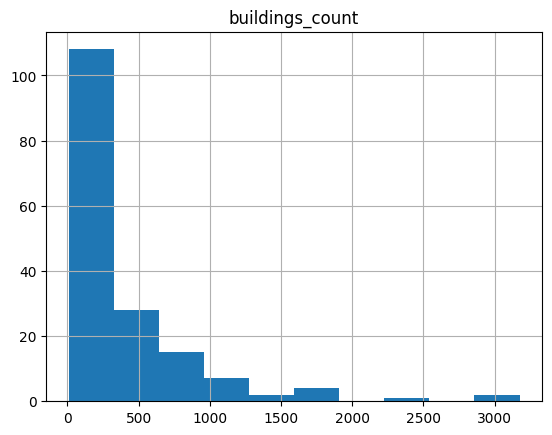

In [29]:
renabap_la_plata.hist("buildings_count")

¿Cómo se compara esto con el número de familias estimado por el propio RENABAP? Para empezar, podemos simplemente dividir el número total de edificios por el número de familias estimado por RENABAP.

In [30]:
print(
    f"Relación edificios por familias RENABAP: {renabap_la_plata['buildings_count'].sum() / renabap_la_plata['familias_aproximadas'].sum():.2f}"
)

Relación edificios por familias RENABAP: 1.89


Interesante--nuestros datos de huellas de edificios sugieren que hay casi _dos_ huellas de edificios por cada familia estimada por RENABAP. Podemos llevar esto un paso más allá y ver si este patrón se mantiene en toda la distribución:

In [31]:
# calcular la relación edificios por familia para cada barrio individualmente
renabap_la_plata["buildings_per_family"] = (
    renabap_la_plata["buildings_count"] / renabap_la_plata["familias_aproximadas"]
)

print("Estadísticas descriptivas - Relación edificios por familia:")
print(renabap_la_plata["buildings_per_family"].describe())

Estadísticas descriptivas - Relación edificios por familia:
count    167.000000
mean       1.829345
std        0.950825
min        0.169713
25%        1.369318
50%        1.765625
75%        2.084886
max        9.621212
Name: buildings_per_family, dtype: float64


Entonces, sí, en promedio, cada asentamiento tiene 1.83 huellas de edificios por familia estimada por RENABAP. ¡Eso plantea algunas preguntas serias!

Ahora, analizaremos nuevamente la correlación como antes, usando el coeficiente de correlación de Spearman. Aquí, dado que asumimos que hay aproximadamente un edificio por familia, también podemos agregar una línea 1:1, que nos muestra—además de la fuerza de la correlación—qué tan cerca están los valores de coincidir perfectamente entre sí.

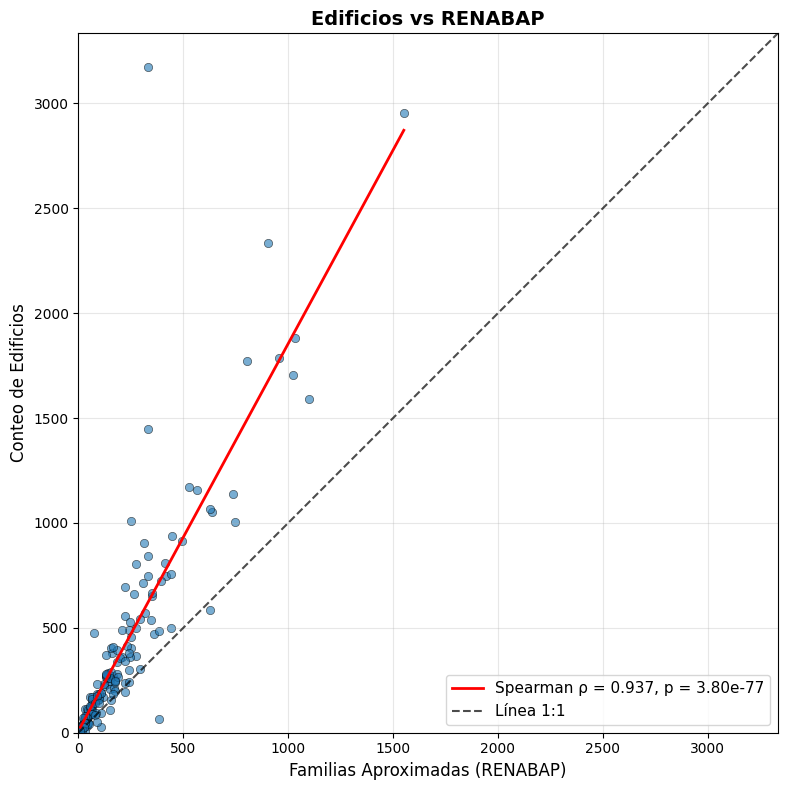

In [32]:
# Crear figura para el gráfico de dispersión
fig, ax = plt.subplots(figsize=(8, 8))

# Graficar la relación entre familias aproximadas (RENABAP) y conteo de edificios
ax.scatter(
    renabap_la_plata["familias_aproximadas"],
    renabap_la_plata["buildings_count"],
    alpha=0.6,
    edgecolors="k",
    linewidth=0.5,
)

# Calcular correlación de Spearman entre familias y edificios
rho, p_value = stats.spearmanr(
    renabap_la_plata["familias_aproximadas"], renabap_la_plata["buildings_count"]
)

# Agregar línea de regresión para referencia
slope, intercept = np.polyfit(
    renabap_la_plata["familias_aproximadas"], renabap_la_plata["buildings_count"], 1
)
x = np.array(
    [
        renabap_la_plata["familias_aproximadas"].min(),
        renabap_la_plata["familias_aproximadas"].max(),
    ]
)
ax.plot(
    x,
    intercept + slope * x,
    "r-",
    linewidth=2,
    label=f"Spearman ρ = {rho:.3f}, p = {p_value:.2e}",
)

# Agregar línea 1:1 para referencia (donde familias = edificios)
max_val = max(
    renabap_la_plata["familias_aproximadas"].max(),
    renabap_la_plata["buildings_count"].max(),
)
# Agregar un pequeño margen para evitar que los puntos en el máximo se corten
max_val_padded = max_val * 1.05
ax.plot(
    [0, max_val_padded],
    [0, max_val_padded],
    "--",
    color="black",
    linewidth=1.5,
    alpha=0.7,
    label="Línea 1:1",
)

# Establecer mismo rango para ambos ejes para comparación 1:1 con margen
ax.set_xlim(0, max_val_padded)
ax.set_ylim(0, max_val_padded)
ax.set_aspect("equal")

ax.set_xlabel("Familias Aproximadas (RENABAP)", fontsize=12)
ax.set_ylabel("Conteo de Edificios", fontsize=12)
ax.set_title("Edificios vs RENABAP", fontsize=14, fontweight="bold")
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Parece que hay una correlación _fuerte_ entre el número de familias estimado por RENABAP y el número de huellas de edificios en nuestro conjunto de datos (rho = 0.937). Esto sugiere que las estimaciones de RENABAP subestiman sistemáticamente el conteo de hogares, posiblemente omitiendo muchas familias. De hecho, podemos calcular aproximadamente cuántas podrían estar faltando restando el número total de familias estimado por RENABAP del número total de edificios:

In [33]:
print(
    f"Diferencia (edificios - familias RENABAP): {renabap_la_plata['buildings_count'].sum() - renabap_la_plata['familias_aproximadas'].sum():,}"
)

Diferencia (edificios - familias RENABAP): 30,211


Si asumimos que cada huella de edificio corresponde más o menos a una familia, y que una familia consiste en un promedio de aproximadamente 3 personas (podría ser más en asentamientos informales), entonces los datos oficiales de RENABAP podrían estar omitiendo algo en el orden de 90,000 personas ¡solo en La Plata!

_Sin embargo_, debemos tener en cuenta dos advertencias importantes: 1) hay muchas situaciones en las que NO hay una familia por edificio (podría haber múltiples edificios por familia O múltiples familias por edificio), y 2) podría haber MÁS de 3 personas por familia O menos. Por lo tanto, esta estimación debe interpretarse como aproximada, no como un número exacto.

Otra forma de abordar esta duda es observar el tamaño _relativo_. En otras palabras, en lugar de intentar comparar familias con individuos con edificios, podemos observar el _ordenamiento_ del tamaño del asentamiento. En teoría, el asentamiento más grande debería permanecer igual, ya sea que lo midamos en familias, individuos o edificios. Sin embargo, si el ordenamiento de los asentamientos según el tamaño difiere significativamente entre las diferentes fuentes de datos, esto sugiere que los sesgos o errores no son uniformes en todos los asentamientos. Por ejemplo, si un asentamiento que ocupa el quinto lugar según RENABAP (familias) ocupa el primer lugar según las huellas de edificios, esto podría indicar que RENABAP está subestimando sistemáticamente ciertos tipos de asentamientos más que otros, en lugar de simplemente tener un factor de corrección constante. Esta discrepancia en el ordenamiento sería más preocupante que simplemente tener diferencias en los valores absolutos, ya que sugiere que los datos no solo están desfasados, sino que también están sesgados de manera diferente según el tipo de asentamiento.

In [34]:
# Crear una tabla simple con los top 10 según cada métrica

# Obtener top 10 para cada métrica
top_familias = renabap_la_plata.nlargest(10, "familias_aproximadas")
top_ghsl_alta = renabap_la_plata.nlargest(10, "ghsl_pop_est_alta")
top_ghsl_baja = renabap_la_plata.nlargest(10, "ghsl_pop_est_baja")
top_edificios = renabap_la_plata.nlargest(10, "buildings_count")

# Crear tabla combinada
comparison_table = pd.DataFrame(
    {
        "Barrio (RENABAP Familias)": top_familias["nombre_barrio"].values,
        "RENABAP Familias": top_familias["familias_aproximadas"].values.astype(int),
        "Barrio (GHSL Alta)": top_ghsl_alta["nombre_barrio"].values,
        "GHSL Alta": top_ghsl_alta["ghsl_pop_est_alta"].values.round(1),
        "Barrio (GHSL Baja)": top_ghsl_baja["nombre_barrio"].values,
        "GHSL Baja": top_ghsl_baja["ghsl_pop_est_baja"].values.round(1),
        "Barrio (Edificios)": top_edificios["nombre_barrio"].values,
        "Edificios": top_edificios["buildings_count"].values.astype(int),
    }
)

display(
    comparison_table.style.set_table_styles(
        [
            {"selector": "th", "props": [("border", "1px solid black")]},
            {"selector": "td", "props": [("border", "1px solid black")]},
        ]
    ).set_properties(**{"border": "1px solid black"})
)

Al examinar los rankings, observamos que los ordenamientos _difieren significativamente_ entre las distintas métricas. Esto es importante porque sugiere que las discrepancias no son uniformes en todos los asentamientos. Tres barrios que aparecen en el top 10 según las huellas de edificios—"Sin Nombre" (primer lugar), "Barrio Nuevo" (noveno lugar) y "La Granjita" (décimo lugar)—no aparecen en absoluto en el top 10 de RENABAP por familias. Del mismo modo, tres barrios que aparecen en el top 10 de RENABAP—"Joel", "Las Palmeras" y "Alegre"—no aparecen en el top 10 de edificios.

Estas diferencias en los rankings son más preocupantes que las discrepancias en los valores absolutos, porque sugieren que RENABAP no está subestimando de manera uniforme. En cambio, parece estar subestimando sistemáticamente ciertos tipos de asentamientos más que otros, posiblemente debido a diferencias en cómo se relevaron o promediaron los datos, o quizás debido a cambios en los asentamientos desde que se recopilaron los datos del censo de 2010 en los que se basan las proyecciones de RENABAP. Esto debería hacernos pensar cuidadosamente sobre cómo usamos estos datos y qué asentamientos podrían necesitar una atención más urgente de lo que sugerirían los datos oficiales de RENABAP.

Finalmente, podemos mapear algunos de estos barrios como ejemplos para comparar un mapa base de imágenes satelitales con los datos de huellas de edificios y ver cómo se corresponden.

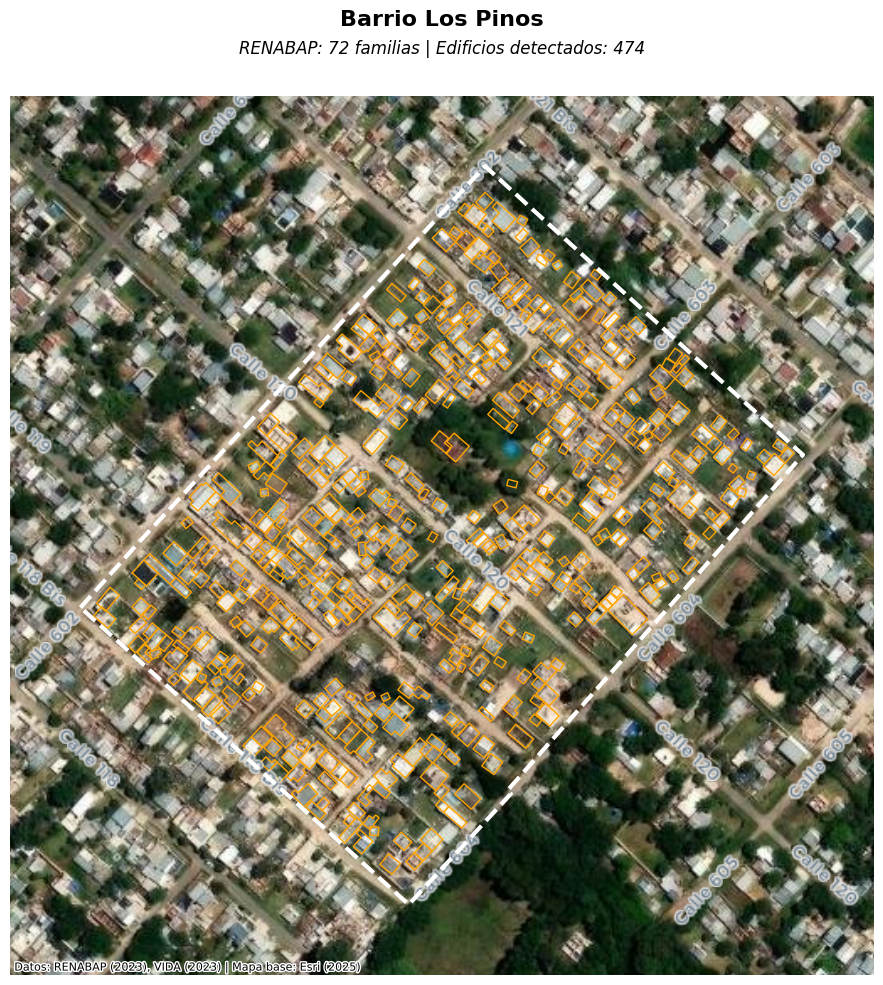

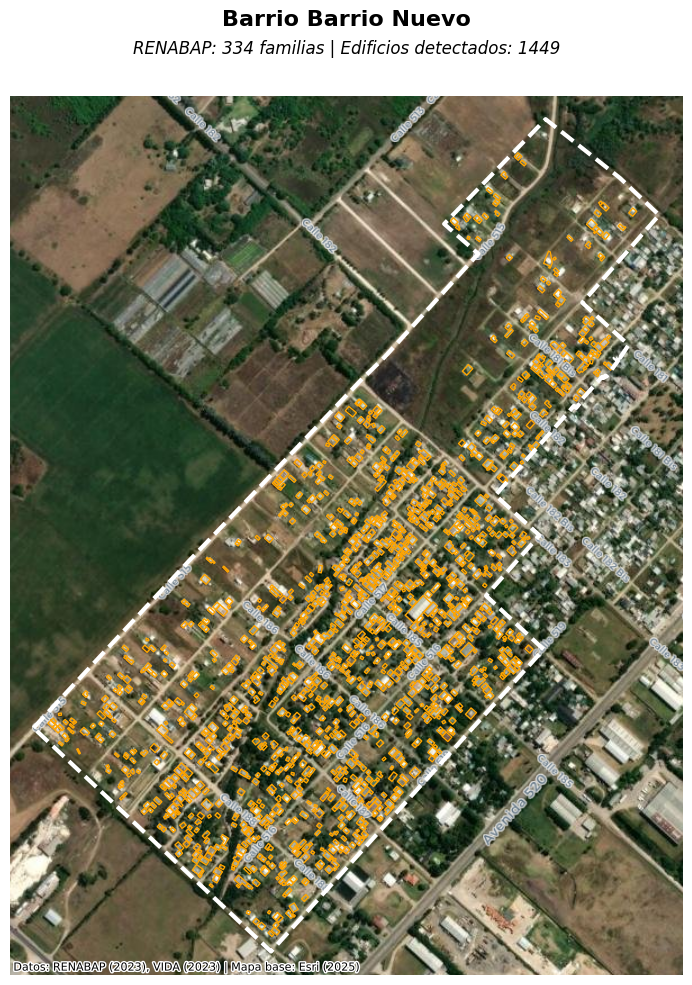

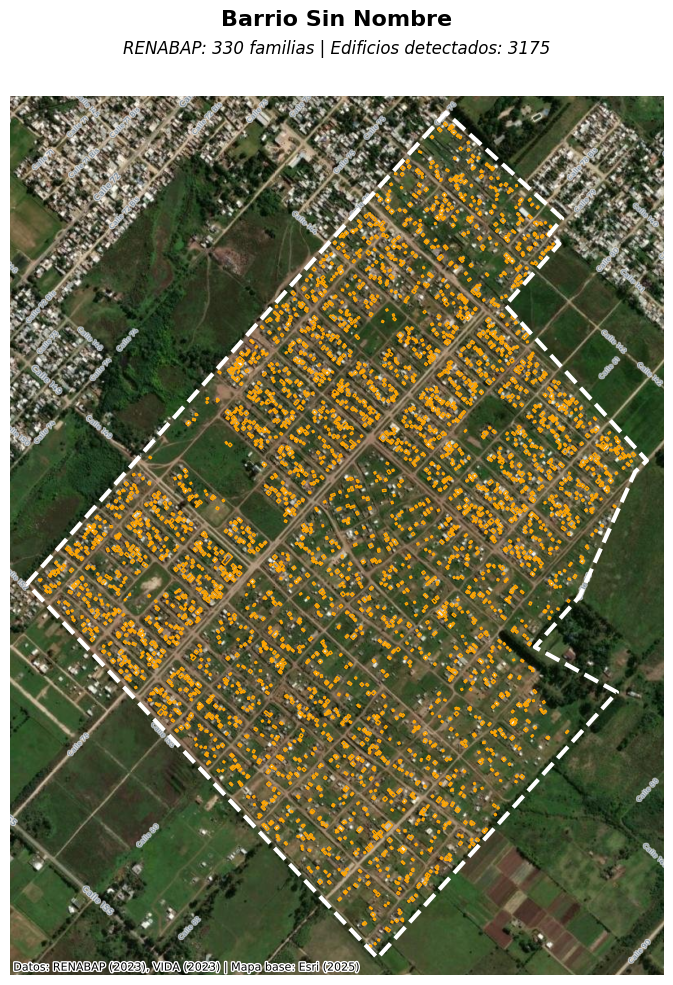

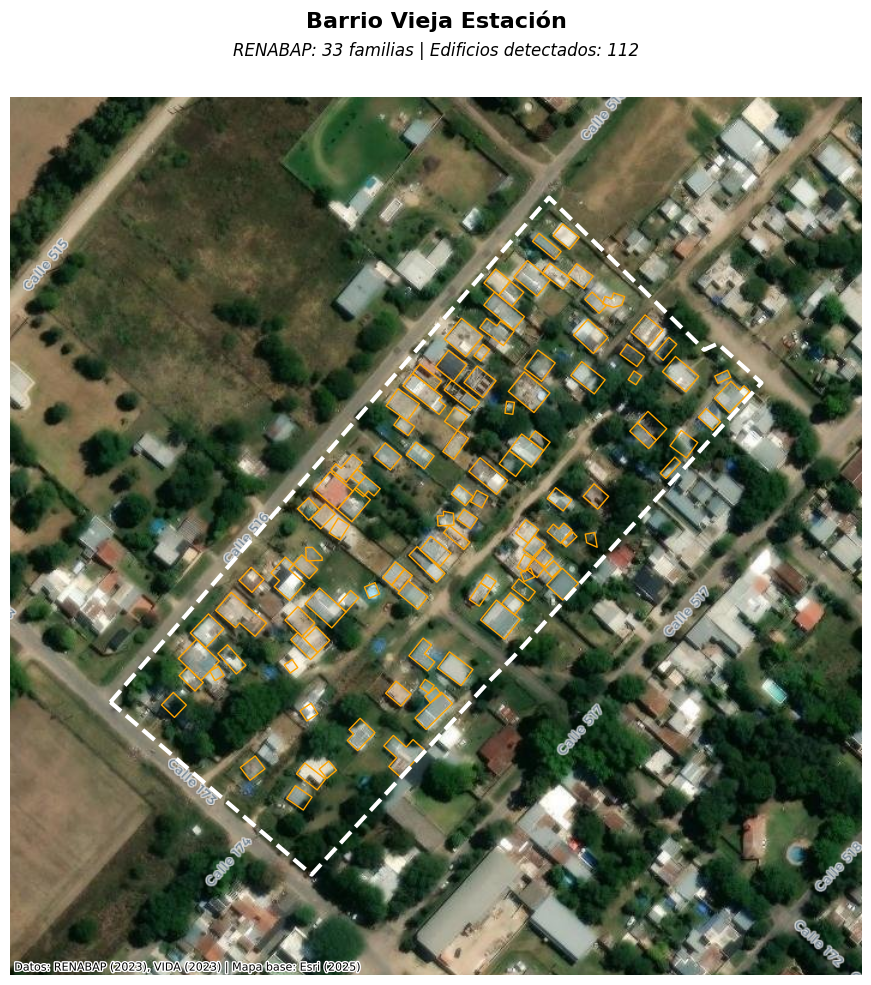

In [35]:
# IDs de los barrios a visualizar
barrio_ids = [5688, 65, 6541, 17]

for i, barrio_id in enumerate(barrio_ids):
    # Filtrar para obtener el barrio específico
    barrio_data = renabap_la_plata[renabap_la_plata["id_renabap"] == barrio_id].copy()

    if len(barrio_data) == 0:
        print(f"No se encontró el barrio con id_renabap {barrio_id}")
        continue

    # Obtener edificios en este barrio
    buildings_data = buildings_in_barrios[
        buildings_in_barrios["id_renabap"] == barrio_id
    ].copy()

    # Convertir a Web Mercator
    barrio_3857 = barrio_data.to_crs(WEB_MERCATOR_CRS)
    buildings_3857 = buildings_data.to_crs(WEB_MERCATOR_CRS)

    # Crear el mapa individual
    fig, ax = plt.subplots(figsize=(10, 10))

    # Configurar límites basados en el barrio
    bounds = barrio_3857.total_bounds
    margin = 50  # metros
    ax.set_xlim(bounds[0] - margin, bounds[2] + margin)
    ax.set_ylim(bounds[1] - margin, bounds[3] + margin)

    # Agregar basemap de contextily
    cx.add_basemap(
        ax,
        crs=WEB_MERCATOR_CRS,
        source=cx.providers.Esri.WorldImagery,
        attribution="Datos: RENABAP (2023), VIDA (2023) | Mapa base: Esri (2025)",
    )

    # Plot de edificios con contorno naranja (sin fill)
    buildings_3857.plot(ax=ax, facecolor="none", edgecolor="orange", linewidth=1)

    # Plot del límite del barrio con estilo consistente
    barrio_3857.plot(
        ax=ax,
        facecolor="none",
        edgecolor="white",
        linewidth=3,
        linestyle="--",
        zorder=10,
    )

    cx.add_basemap(
        ax,
        crs=WEB_MERCATOR_CRS,
        source=cx.providers.CartoDB.PositronOnlyLabels,
        attribution="",
    )

    # Obtener información del barrio
    barrio_nombre = barrio_data["nombre_barrio"].iloc[0]
    familias_renabap = int(barrio_data["familias_aproximadas"].iloc[0])
    total_edificios = len(buildings_data)

    # Título principal usando suptitle
    fig.suptitle(f"Barrio {barrio_nombre}", fontsize=16, fontweight="bold", y=0.98)

    # Subtítulo usando title
    ax.set_title(
        f"RENABAP: {familias_renabap} familias | Edificios detectados: {total_edificios}",
        fontsize=12,
        style="italic",
        pad=30,
    )

    # Limpiar el mapa
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.tight_layout()
    plt.show()

Estos mapas dejan claro que los datos de huellas de edificios son confiables. Aunque pueden no ser perfectos, compararlos con imágenes satelitales muestra que definitivamente hay _más_ edificios en estos asentamientos de lo que sugerirían los datos de RENABAP. Esto debería hacernos pensar sobre cómo usamos cada uno de los datos de RENABAP, los datos de GHSL y las huellas de edificios.

Dicho esto, no podemos simplemente asumir que hay una relación 1:1 entre edificios y familias: en algunos casos, múltiples edificios pueden pertenecer a una familia, y en otros, múltiples familias pueden vivir en un solo edificio. Para tener claridad sobre esto, tendríamos que ir y hacer validación de campo de estos datos—¡lo cual está fuera del alcance de esta lección!

En cambio, lo que deberíamos llevarnos es una comprensión de haber usado tres conjuntos de datos diferentes—uno argentino y dos globales—para entender mejor los asentamientos informales. Nos vamos con más preguntas que respuestas—¡y eso está bien! Hemos usado nuestras habilidades de análisis de datos para entender mejor la calidad y confiabilidad de estos datos, y ahora podremos aplicarlos con una mejor comprensión de sus fortalezas y limitaciones. Esto es mucho más importante que simplemente usarlos a ciegas, y nos hace analistas de datos mucho mejores.